## Download and Import

In [21]:
!pip install librosa
!pip install torch

In [41]:
import os
import pandas as pd
import s3fs
import zipfile
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy import signal

In [42]:
DATASET_PATH = "data/LivingRoom_preprocessed_hack"

## Download Dataset

In [4]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [5]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [6]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [7]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

[None]

In [8]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

## Read Data

In [43]:
centroids = np.load(DATASET_PATH + "/Human1/centroid.npy")
deconvoled_trim = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
skeletons = np.load(DATASET_PATH + "/Human1/skeletons.npy")

In [44]:
print("Skeletons Shape: ", skeletons.shape)
print("Deconvoled Trim Shape: ", deconvoled_trim.shape)
print("Centroids Shape: ", centroids.shape)

Skeletons Shape:  (1000, 3, 32, 3)
Deconvoled Trim Shape:  (1000, 4, 667200)
Centroids Shape:  (1000, 2)


In [45]:
df_centroid = pd.DataFrame(centroids, columns=['x', 'y'])
df_centroid

,x,y
0,-3231.329347,-1127.877715
1,-3198.541079,-744.510066
2,-3192.977627,-248.266788
3,-3018.418253,334.938546
4,-3015.779532,826.440201
...,...,...
995,-2232.655302,-3227.790684
996,-2230.893046,-2974.853017
997,-1717.899236,-3166.596485
998,-1808.603375,-2779.130384


## Visualize Data

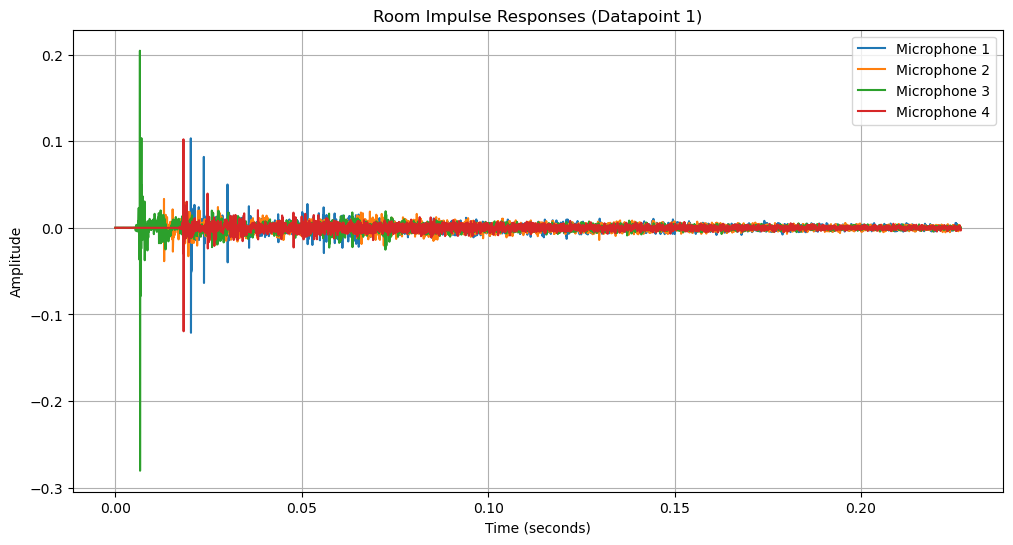

In [14]:
N_datapoints, N_Microphones, N_samples = deconvoled_trim.shape

datapoint_index = 1  # Choose the datapoint index
time_sample_start = 0  # Start index of time samples
time_sample_end = 10000  # End index of time samples (or choose a specific range)

sampling_rate = 44100
time_axis = np.arange(time_sample_end - time_sample_start) / sampling_rate

# Plot the RIRs for each microphone channel
plt.figure(figsize=(12, 6))
for microphone_index in range(N_Microphones):
    # Extract the RIR for the current microphone channel
    rir = deconvoled_trim[datapoint_index, microphone_index, time_sample_start:time_sample_end]
    
    # Plot the RIR on the same figure with different colors for each microphone
    plt.plot(time_axis, rir, label=f"Microphone {microphone_index + 1}")

plt.title(f"Room Impulse Responses (Datapoint {datapoint_index})")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


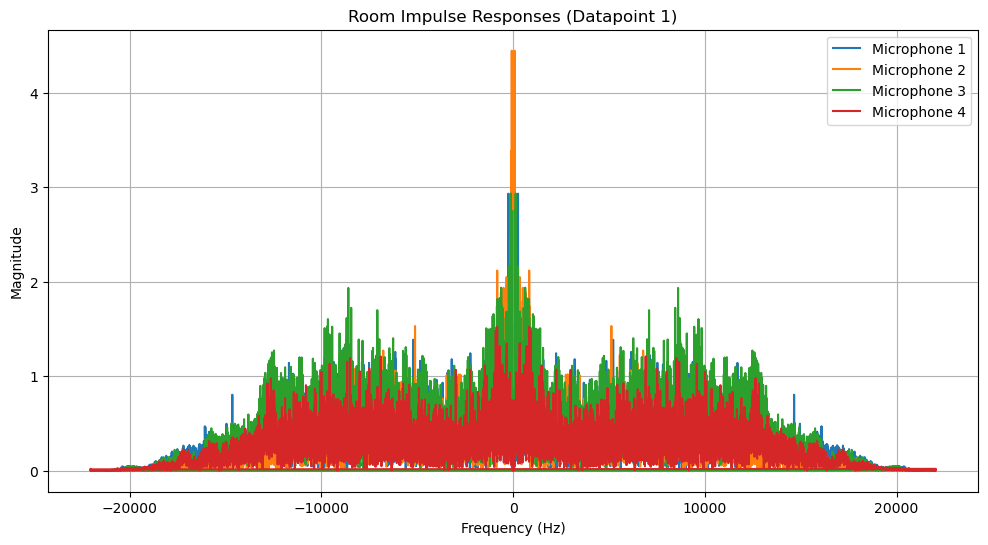

In [15]:
# Plot the RIRs for each microphone channel in the frequency domain
plt.figure(figsize=(12, 6))
for microphone_index in range(N_Microphones):
    # Extract the RIR for the current microphone channel
    rir = deconvoled_trim[datapoint_index, microphone_index, time_sample_start:time_sample_end]
    
    # Compute the FFT
    rir_fft = np.fft.fft(rir)
    
    # Compute the frequency axis
    freq_axis = np.fft.fftfreq(len(rir), 1 / sampling_rate)
    
    # Plot the magnitude of the FFT (absolute value)
    plt.plot(freq_axis, np.abs(rir_fft), label=f"Microphone {microphone_index + 1}")

plt.title(f"Room Impulse Responses (Datapoint {datapoint_index})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()

## Preprocessing Data

In [46]:
sampling_rate = 44100
preprocessed_data_mfcc = []
preprocessed_data_rms = []
preprocessed_data_zcr = []

for instance_index in range(deconvoled_trim.shape[0]):
    instance_data_mfcc = []
    instance_data_zcr = []
    instance_data_rms = []
    for channel_index in range(deconvoled_trim.shape[1]):
        # Filtering
        filtered_signal = signal.medfilt(deconvoled_trim[instance_index, channel_index, :], kernel_size=3)
        
        # Normalization
        normalized_signal = librosa.util.normalize(filtered_signal)
        
        # Resampling
        resampled_signal = librosa.resample(normalized_signal, orig_sr=sampling_rate, target_sr=16000)
        
        # Feature extraction

        # MFCC features
        mfcc_features = librosa.feature.mfcc(y=resampled_signal, sr=16000, n_mfcc=13)
        # RMS Energy
        rms_features = librosa.feature.rms(y=resampled_signal)
        # Zero-Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=resampled_signal)
        
        instance_data_mfcc.append(mfcc_features)
        instance_data_zcr.append(zero_crossing_rate)
        instance_data_rms.append(rms_features)
    
    preprocessed_data_mfcc.append(instance_data_mfcc)
    preprocessed_data_rms.append(instance_data_rms)
    preprocessed_data_zcr.append(instance_data_zcr)

preprocessed_data_mfcc = np.array(preprocessed_data_mfcc)
preprocessed_data_rms = np.array(preprocessed_data_rms)
preprocessed_data_zcr = np.array(preprocessed_data_zcr)

In [47]:
def plot_audio_features(instance_index, channel_index, mfcc_features=[], rms_features=[], zero_crossing_rate=[]):
    if len(mfcc_features) > 0:
        # Plot MFCC features
        plt.figure(figsize=(10, 4))
        plt.imshow(mfcc_features, cmap='viridis', origin='lower', aspect='auto')
        plt.xlabel('Frame')
        plt.ylabel('MFCC Coefficient')
        plt.title('MFCC Features (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
        plt.colorbar(label='Magnitude')
        plt.tight_layout()
        plt.show()

    if len(rms_features) > 0:
        # Plot RMS Features for each channel
        for i, rms_channel in enumerate(rms_features):
            plt.figure(figsize=(10, 4))
            plt.plot(rms_channel, label=f'RMS Features (Channel {i+1})')
            plt.xlabel('Time (frame)')
            plt.ylabel('RMS Energy')
            plt.title('RMS Features (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
            plt.legend()
            plt.tight_layout()
            plt.show()

    if len(zero_crossing_rate) > 0:
        # Plot Zero-Crossing Rate for each channel
        for i, zcr_channel in enumerate(zero_crossing_rate):
            plt.figure(figsize=(10, 4))
            plt.plot(zcr_channel, label=f'Zero-Crossing Rate (Channel {i+1})')
            plt.xlabel('Time (frame)')
            plt.ylabel('Zero-Crossing Rate')
            plt.title('Zero-Crossing Rate (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
            plt.legend()
            plt.tight_layout()
            plt.show()

In [48]:
print(preprocessed_data_rms.shape)
print(preprocessed_data_zcr.shape)
print(preprocessed_data_mfcc.shape)

(1000, 4, 1, 473)
(1000, 4, 1, 473)
(1000, 4, 13, 473)


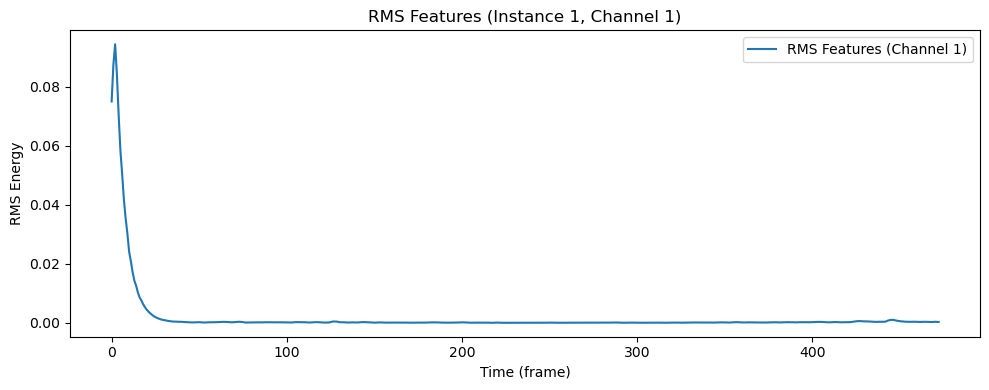

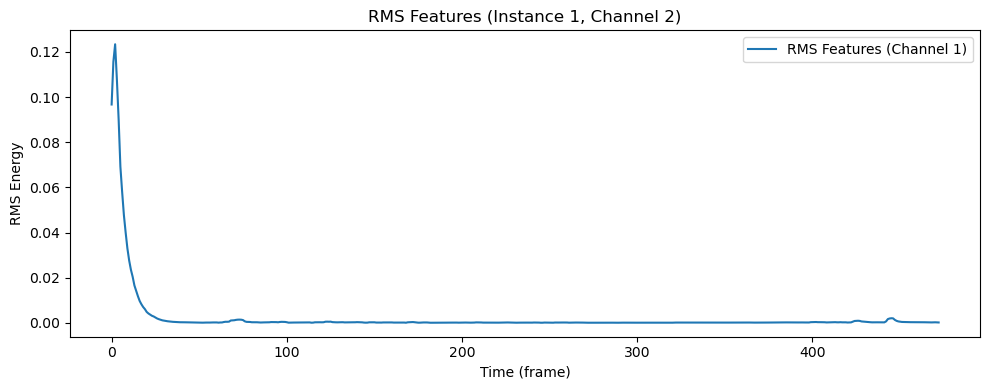

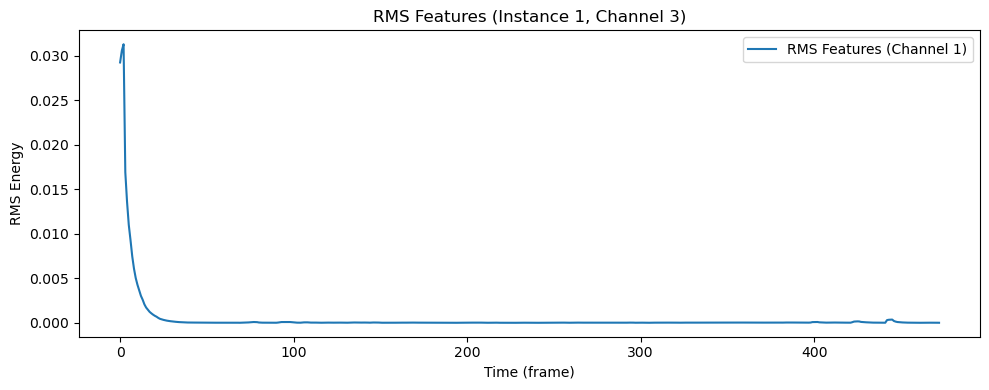

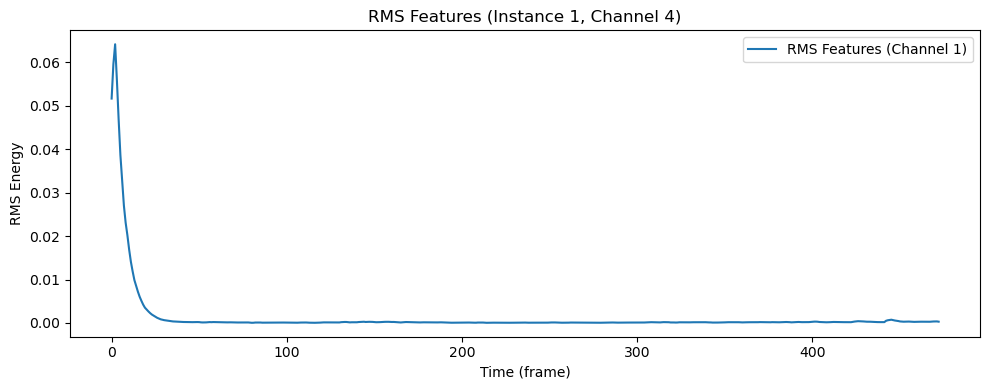

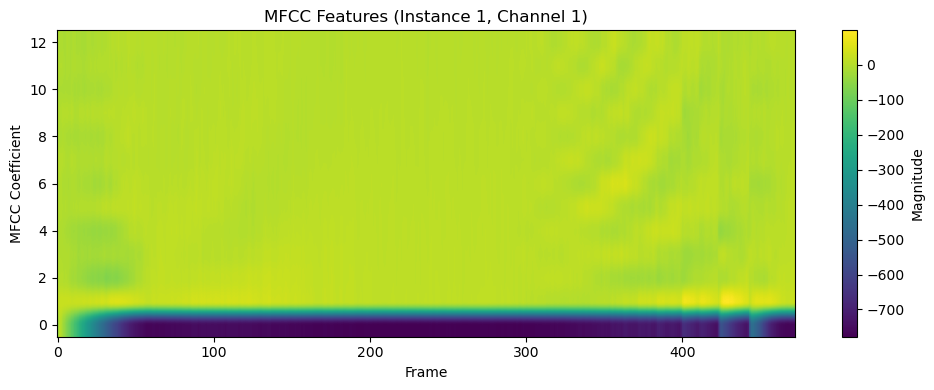

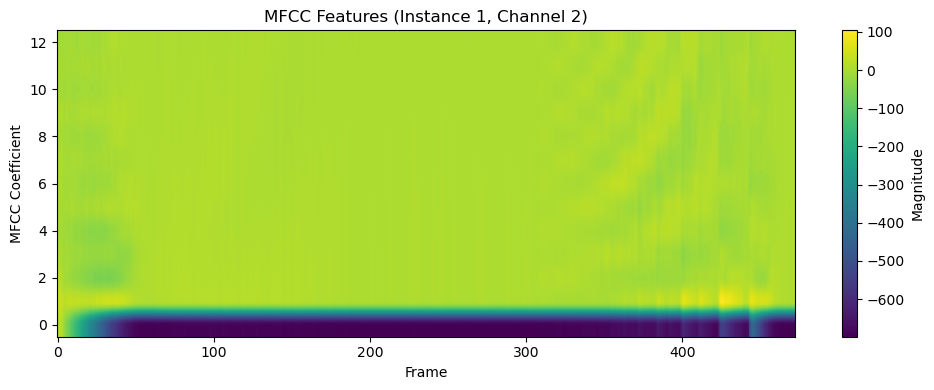

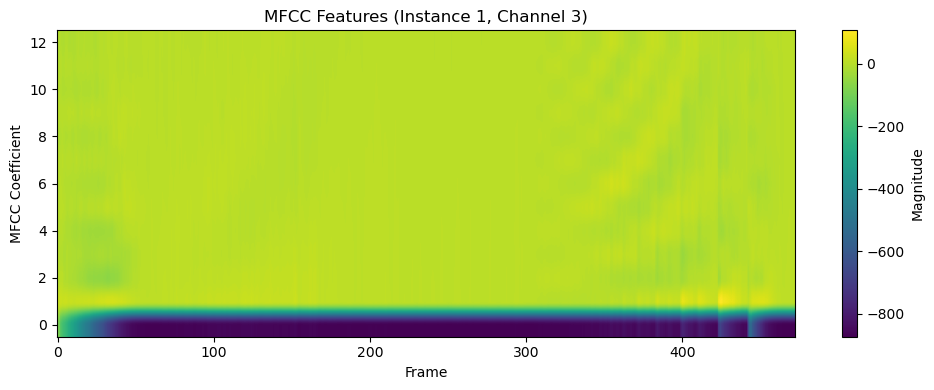

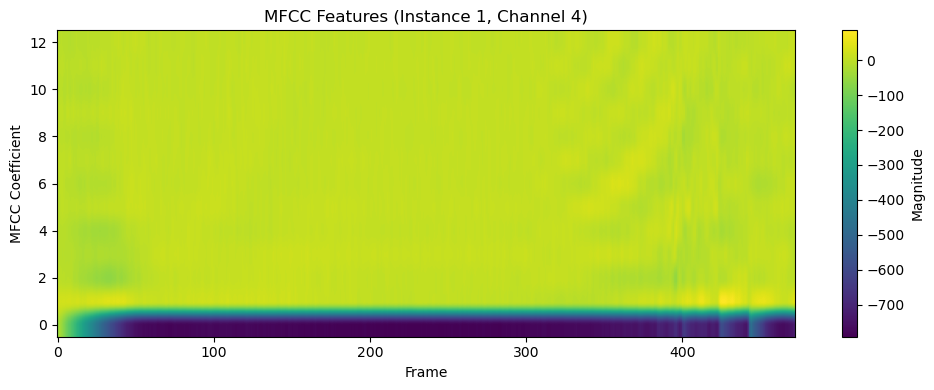

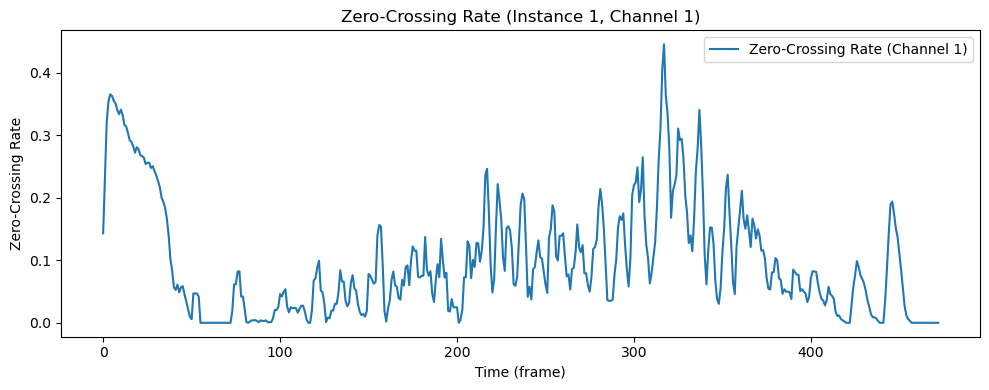

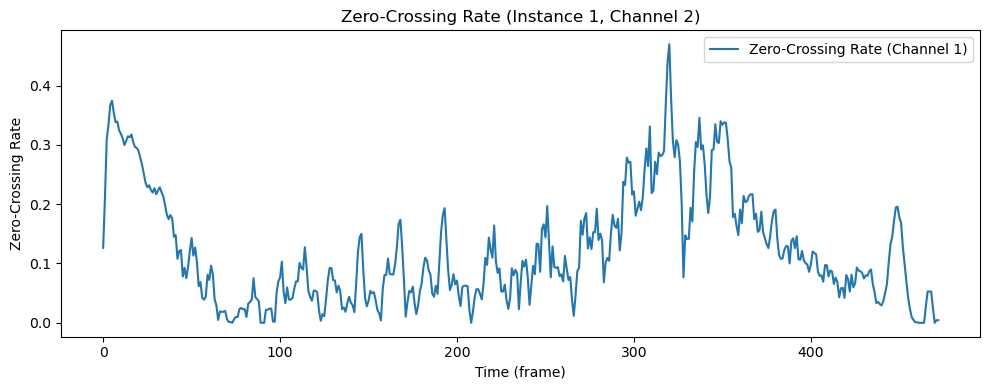

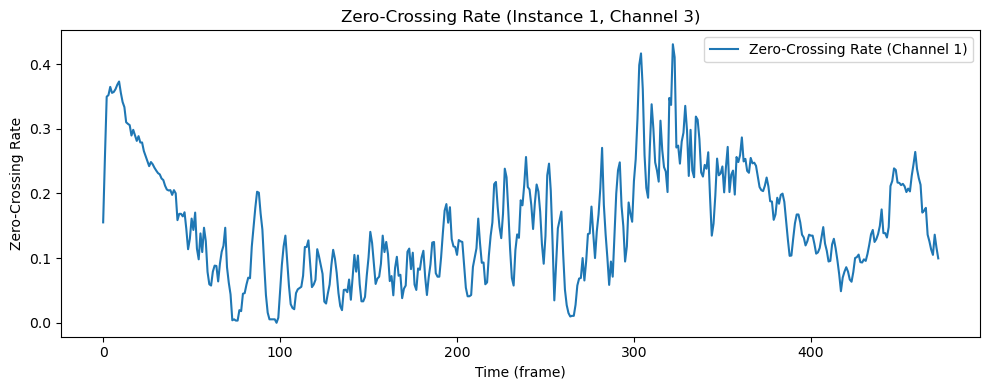

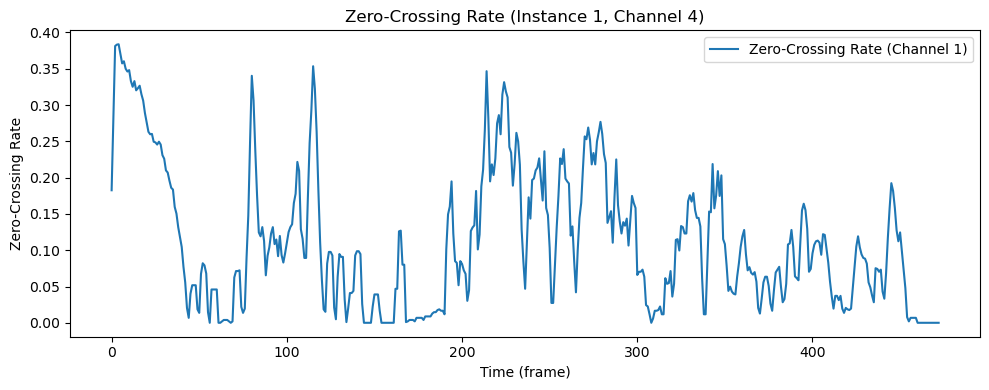

In [49]:
# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_rms.shape[0]):
    for channel_index in range(preprocessed_data_rms.shape[1]):
        rms_features = preprocessed_data_rms[instance_index, channel_index]
        plot_audio_features(rms_features=rms_features, instance_index=instance_index, channel_index=channel_index)
    break

# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_mfcc.shape[0]):
    for channel_index in range(preprocessed_data_mfcc.shape[1]):
        mfcc_features = preprocessed_data_mfcc[instance_index, channel_index]
        plot_audio_features(mfcc_features=mfcc_features, instance_index=instance_index, channel_index=channel_index)
    break

# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_zcr.shape[0]):
    for channel_index in range(preprocessed_data_zcr.shape[1]):
        zero_crossing_rate = preprocessed_data_zcr[instance_index, channel_index] 
        plot_audio_features(zero_crossing_rate=zero_crossing_rate, instance_index=instance_index, channel_index=channel_index)
    break

## Model

In [61]:
class CustomDataset(Dataset):
    def __init__(self, preprocessed_data_mfcc, coordinates, preprocessed_data_rms=[], preprocessed_data_zcr=[]):
        self.preprocessed_data_mfcc = preprocessed_data_mfcc
        self.preprocessed_data_rms = preprocessed_data_rms
        self.preprocessed_data_zcr = preprocessed_data_zcr
        self.coordinates = coordinates
        
    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        mfcc = self.preprocessed_data_mfcc[idx]
        rms = self.preprocessed_data_rms[idx]
        zcr = self.preprocessed_data_zcr[idx]
        coordinates = self.coordinates[idx]
        
        # Convert to PyTorch tensors
        mfcc = torch.tensor(mfcc, dtype=torch.float32)
        rms = torch.tensor(rms, dtype=torch.float32)
        zcr = torch.tensor(zcr, dtype=torch.float32)
        coordinates = torch.tensor(coordinates, dtype=torch.float32)
        
        return rms, coordinates

    def __getitem__(self, idx):
        mfcc = [torch.tensor(self.preprocessed_data_mfcc[idx, mic_index], dtype=torch.float32) for mic_index in range(4)]
        rms = torch.tensor(self.preprocessed_data_rms[idx], dtype=torch.float32) if self.preprocessed_data_rms is not None else None
        zcr = torch.tensor(self.preprocessed_data_zcr[idx], dtype=torch.float32) if self.preprocessed_data_zcr is not None else None
        coordinates = torch.tensor(self.coordinates[idx], dtype=torch.float32)
        
        return rms, coordinates

In [65]:
# Define the custom dataset
dataset = CustomDataset(preprocessed_data_mfcc, centroids, preprocessed_data_rms, preprocessed_data_zcr)

# Access a sample from the dataset
mfcc_list, coordinates = dataset[1]
print("MFCC List Length:", len(mfcc_list))
print("MFCC Shape (Microphone 1):", mfcc_list[0].shape)
print("MFCC Shape (Microphone 2):", mfcc_list[1].shape)
print("MFCC Shape (Microphone 3):", mfcc_list[2].shape)
print("MFCC Shape (Microphone 4):", mfcc_list[3].shape)
print("Coordinates:", coordinates)

RMS List Length: 4
RMS Shape (Microphone 1): torch.Size([1, 473])
RMS Shape (Microphone 2): torch.Size([1, 473])
RMS Shape (Microphone 3): torch.Size([1, 473])
RMS Shape (Microphone 4): torch.Size([1, 473])
Coordinates: tensor([-3198.5410,  -744.5101])
